In [1]:
import gaiaxpy as gxp
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sdss

from astroML.sum_of_norms import sum_of_norms, norm
from astroquery.sdss import SDSS as aq_sdss
from scipy.optimize import curve_fit

In [2]:
# data-relevant constants
DF = pd.read_csv('../data/gaia_sdss_joined.csv')
FIGURE_PATH = '../figures'

GAIA_ID_COLNAME = 'source_id'
SDSS_ID_COLNAME = 'specObjId'
NUM_NORMS = 800

In [3]:
# plot fontsize settings

SMALL_FONT_SIZE = 16
MEDIUM_FONT_SIZE = 20
LARGE_FONT_SIZE = 20

plt.rc('font', size=SMALL_FONT_SIZE)          # default text sizes
plt.rc('axes', titlesize=LARGE_FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_FONT_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_FONT_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_FONT_SIZE)   # fontsize of the figure title

In [4]:
# line properties

PROPS = {
    'sdss_raw': { 'color': '#AAAAAA', 'ls': '--', 'lw': 1, 'label': 'SDSS flux' },
    'gaussian': { 'color': '#FF4444', 'ls': '-', 'lw': 2, 'label': 'Gaussian fit to SDSS flux' },
    'gaia': {'color': '#4444FF', 'ls': '-', 'lw': 2, 'label': 'Gaia flux' }
}

In [5]:
def plot_w_props(x, y, props):
    plt.plot(x, y, color=props['color'], ls=props['ls'], lw=props['lw'], label=props['label'])

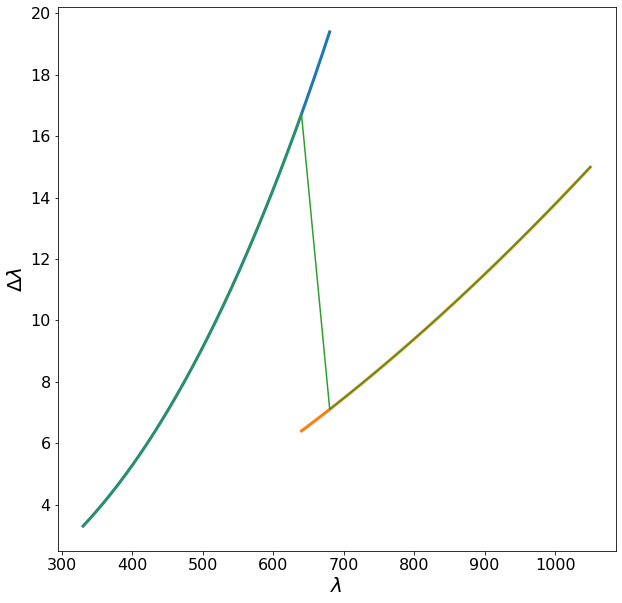

In [6]:
x1 = np.linspace(330, 680, 1000)
y1 = 3.30 * (x1/330)**2.45

x2 = np.linspace(640, 1050, 1000)
y2 = 6.40 * (x2/640)**1.72

plt.figure(figsize=(10, 10))
plt.plot(x1, y1, lw=3)
plt.plot(x2, y2, lw=3)

def deltaXP(wvl):
    y1 = lambda x: 3.30 * (x/330)**2.45
    y2 = lambda x: 6.40 * (x/640)**1.72
    y_mid = lambda x: (y2(680) * (x - 640) + y1(640) * (680 - x))/40
    
    return np.piecewise(wvl, \
                        [wvl < 640, (640 <= wvl) & (wvl <= 680), wvl > 680], \
                        [y1, y_mid, y2])
#     return np.piecewise(wvl, \
#                         [wvl < 660, wvl >= 660], \
#                         [y1, y2])
    
x = np.linspace(330, 1050, 2000)
plt.xlabel('$\\lambda$')
plt.ylabel('$\\Delta\\lambda$')
plt.plot(x, deltaXP(x))

In [7]:
def plot_conv(*, gaia_id=None, sdss_id=None, k=1):
    if gaia_id is None and sdss_id is None:
        print('No ID supplied')
    elif sdss_id is None:    
        try:
            sdss_id = DF.loc[DF[GAIA_ID_COLNAME] == gaia_id][SDSS_ID_COLNAME].to_list()[0]
        except:
            print('Could not find an SDSS ID corresponding to the provided Gaia ID')
    elif gaia_id is None:
        try:
            gaia_id = DF.loc[DF[SDSS_ID_COLNAME] == sdss_id][GAIA_ID_COLNAME].to_list()[0]
        except:
            print('Could not find an Gaia ID corresponding to the provided SDSS ID')
            
    # get sdss data
    try:
        sp = sdss.SpecObj(int(sdss_id))
        data = aq_sdss.get_spectra(plate=sp.plate, mjd=sp.mjd, fiberID=sp.fiberID)
    except:
        print('Could not get SDSS data')
        return
    
    spec_data = data[0][1].data

    sdss_sampling = 10 ** spec_data['loglam'] / 10  # Convert log wavelength to linear and Å to nm
    sdss_flux = spec_data['flux'] * 1e-19 # Convert SDSS units (1e-17 in cgs) to Gaia units (SI)
    
    # const (test)
#     sdss_flux = np.array([np.mean(sdss_flux)] * len(sdss_flux))
    
    # get gaia data and calibrate using sdss sampling
    gaia_flux = gxp.calibrate([gaia_id], sampling=sdss_sampling, truncation=True)[0]['flux'][0]

    weights, fit_rms, locs, widths = sum_of_norms(sdss_sampling, sdss_flux, NUM_NORMS,
                                                 spacing='linear',
                                                 full_output=True)
    
    # convolve sdss with sigma_gaia
#     sigma_conv = np.sqrt(widths**2 + k**2 * deltaXP(locs)**2)  # convolve gaussian sigmas with sigma_gaia
    sigma_conv = np.sqrt(widths**2 + k**2 * deltaXP(sdss_sampling[:, None])**2)  # convolve gaussian sigmas with sigma_gaia
    sdss_flux_fit = (weights * norm(sdss_sampling[:, None], locs, widths)).sum(1)
    sdss_conv = (weights * norm(sdss_sampling[:, None], locs, sigma_conv)).sum(1)
    
    # integrate flux as sanity check
    mask = (sdss_sampling > 390) & (sdss_sampling < 900)
    raw_flux = np.trapz(sdss_flux[mask], sdss_sampling[mask])
    fit_flux = np.trapz(sdss_flux_fit[mask], sdss_sampling[mask])
    conv_flux = np.trapz(sdss_conv[mask], sdss_sampling[mask])
    
    # compute rms error and quotient between sdss convolution and gaia data
    match_rms = np.sqrt(np.mean((sdss_conv[mask] - gaia_flux[mask])**2))
    quot = np.mean(sdss_conv[mask]/gaia_flux[mask])

    # plot the results

    plt.figure(figsize=(20, 10))
    plot_w_props(sdss_sampling, sdss_flux, PROPS['sdss_raw'])
    plot_w_props(sdss_sampling, sdss_conv, PROPS['gaussian'])
    plot_w_props(sdss_sampling, gaia_flux, PROPS['gaia'])

    plt.legend(loc=0)

    plt.text(0.97, 0.8, f"gaussian fit rms error = {fit_rms:.2}", ha='right', va='top', transform=plt.gca().transAxes)
    plt.text(0.97, 0.75, f"k = {k:.2}", ha='right', va='top', transform=plt.gca().transAxes)
    plt.text(0.97, 0.7, f"sdss - gaia rms error = {match_rms:.3}", ha='right', va='top', transform=plt.gca().transAxes)
    plt.text(0.97, 0.65, f"sdss/gaia quotient = {quot:.3}", ha='right', va='top', transform=plt.gca().transAxes)
    plt.text(0.97, 0.6, f"integrated flux (raw) = {raw_flux:.5}", ha='right', va='top', transform=plt.gca().transAxes)
    plt.text(0.97, 0.55, f"integrated flux (fit) = {fit_flux:.5}", ha='right', va='top', transform=plt.gca().transAxes)
    plt.text(0.97, 0.5, f"integrated flux (conv) = {conv_flux:.5}", ha='right', va='top', transform=plt.gca().transAxes)
    plt.title(f"Gaia source_id {gaia_id}\n SDSS specObjId {sdss_id}")
    
    plt.xlabel('$\\lambda$ [nm]')
    plt.ylabel('flux [W m$^{-2}$ nm$^{-1}$]')
    
    plt.xlim(350, 950)
    plt.xticks(np.arange(360, 960, 20))
    
    for axis in [ 'top', 'bottom', 'left', 'right' ]:
        plt.gca().spines[axis].set_linewidth(2)
    
    if not os.path.exists(FIGURE_PATH):
        os.mkdir(FIGURE_PATH)

    plt.savefig(f'{FIGURE_PATH}/gaia_{gaia_id}_sdss_{sdss_id}_k_{int(k*10)}.png')
    plt.show()

In [8]:
def plot_conv_get_gaia(*, gaia_id=None, sdss_id=None):
    if gaia_id is None and sdss_id is None:
        print('No ID supplied')
    elif sdss_id is None:    
        try:
            sdss_id = DF.loc[DF[GAIA_ID_COLNAME] == gaia_id][SDSS_ID_COLNAME].to_list()[0]
        except:
            print('Could not find an SDSS ID corresponding to the provided Gaia ID')
    elif gaia_id is None:
        try:
            gaia_id = DF.loc[DF[SDSS_ID_COLNAME] == sdss_id][GAIA_ID_COLNAME].to_list()[0]
        except:
            print('Could not find an Gaia ID corresponding to the provided SDSS ID')
            
    # get sdss data
    try:
        sp = sdss.SpecObj(int(sdss_id))
        data = aq_sdss.get_spectra(plate=sp.plate, mjd=sp.mjd, fiberID=sp.fiberID)
    except:
        print('Could not get SDSS data')
        return
    
    spec_data = data[0][1].data

    sdss_sampling = 10 ** spec_data['loglam'] / 10  # Convert log wavelength to linear and Å to nm
    sdss_flux = spec_data['flux'] * 1e-19 # Convert SDSS units (1e-17 in cgs) to Gaia units (SI)
    
    # get gaia data and calibrate using sdss sampling
    while True:
        try:
            print('calibrating gaia...')
            gaia_flux = gxp.calibrate([gaia_id], sampling=sdss_sampling, truncation=True)[0]['flux'][0]
            print('done.')
            return gaia_flux
        except Exception as e:
            print(e)
            continue

In [9]:
def plot_conv_k_rms(gaia_flux, *, gaia_id=None, sdss_id=None, k=1):
    if gaia_id is None and sdss_id is None:
        print('No ID supplied')
    elif sdss_id is None:    
        try:
            sdss_id = DF.loc[DF[GAIA_ID_COLNAME] == gaia_id][SDSS_ID_COLNAME].to_list()[0]
        except:
            print('Could not find an SDSS ID corresponding to the provided Gaia ID')
    elif gaia_id is None:
        try:
            gaia_id = DF.loc[DF[SDSS_ID_COLNAME] == sdss_id][GAIA_ID_COLNAME].to_list()[0]
        except:
            print('Could not find an Gaia ID corresponding to the provided SDSS ID')
            
    # get sdss data
    try:
        sp = sdss.SpecObj(int(sdss_id))
        data = aq_sdss.get_spectra(plate=sp.plate, mjd=sp.mjd, fiberID=sp.fiberID)
    except:
        print('Could not get SDSS data')
        return
    
    spec_data = data[0][1].data

    sdss_sampling = 10 ** spec_data['loglam'] / 10  # Convert log wavelength to linear and Å to nm
    sdss_flux = spec_data['flux'] * 1e-19 # Convert SDSS units (1e-17 in cgs) to Gaia units (SI)
    
    weights, fit_rms, locs, widths = sum_of_norms(sdss_sampling, sdss_flux, NUM_NORMS,
                                                 spacing='linear',
                                                 full_output=True)
    
    # convolve sdss with sigma_gaia
    sigma_conv = np.sqrt(widths**2 + k**2 * deltaXP(sdss_sampling[:, None])**2)  # convolve gaussian sigmas with sigma_gaia
    sdss_flux_fit = (weights * norm(sdss_sampling[:, None], locs, widths)).sum(1)
    sdss_conv = (weights * norm(sdss_sampling[:, None], locs, sigma_conv)).sum(1)
    
    # integrate flux as sanity check
    mask = (sdss_sampling > 390) & (sdss_sampling < 900)
    raw_flux = np.trapz(sdss_flux[mask], sdss_sampling[mask])
    fit_flux = np.trapz(sdss_flux_fit[mask], sdss_sampling[mask])
    conv_flux = np.trapz(sdss_conv[mask], sdss_sampling[mask])
    
    # compute rms error and quotient between sdss convolution and gaia data
    match_rms = np.sqrt(np.mean((sdss_conv[mask] - gaia_flux[mask])**2))
    quot = np.median(sdss_conv/gaia_flux)

    return match_rms, quot

In [10]:
ks = {}
qs = {}
for gaia_id in DF[:1000][GAIA_ID_COLNAME]:
    min_k, min_rmse, min_q = 100, 100, 100
    gaia_flux = plot_conv_get_gaia(gaia_id=gaia_id)
    if gaia_flux is None:
        continue
            
    for k in np.arange(0.20, 1.800001, 0.02):
        rmse, q = plot_conv_k_rms(gaia_flux, gaia_id=gaia_id, k=k)
        if rmse < min_rmse:
            min_rmse = rmse
            min_k = k
            min_q = q
        else:
            break
        
    ks[gaia_id] = min_k
    qs[gaia_id] = min_q

calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.   0/1 [00:00<?, ?spec/s]
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.   0/1 [00:00<?, ?spec/s]
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.   0/1 [00:00<?, ?spec/s]
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.   0/1 [00:00<?, ?spec/s]
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.   0/1 [00:00<?, ?spec/s]
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
Could not get SDSS data
Could not get SDSS data
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
Could not get SDSS data
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
Could not get SDSS data
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
Could not get SDSS data
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
Could not get SDSS data
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
Could not get SDSS data
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
Could not get SDSS data
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
Could not get SDSS data
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
Could not get SDSS data
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
Could not get SDSS data
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
Could not get SDSS data
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
Could not get SDSS data
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


In [11]:
ks

{3217536339907648384: 0.5799999999999998,
 3697743267334291328: 1.7999999999999992,
 3683666666640754048: 0.6799999999999997,
 3683528776714709632: 0.6199999999999999,
 3683494176458551808: 0.5399999999999998,
 3658537736409397888: 1.5199999999999994,
 3694803688638177280: 0.31999999999999995,
 3649721512875483904: 0.3999999999999999,
 3652755958809710464: 0.5399999999999998,
 3695425290664568704: 0.4599999999999999,
 3649003463063106304: 1.7999999999999992,
 3217961747828046080: 1.7999999999999992,
 3683515410776636800: 1.7999999999999992,
 3217574234403744000: 0.4599999999999999,
 3637758792005488896: 0.41999999999999993,
 3073311956582747392: 0.5799999999999998,
 3694818222807582080: 0.5399999999999998,
 3793876214650688640: 0.29999999999999993,
 3661566306828100224: 0.4599999999999999,
 3659347256140256256: 0.9599999999999995,
 3685958598628554240: 0.2,
 3602512675468007808: 0.3999999999999999,
 3083085790322125056: 1.2199999999999995,
 3695495659409680896: 1.7999999999999992,
 383

In [12]:
qs

{3217536339907648384: 1.0536705832381164,
 3697743267334291328: 1.0966033687689638,
 3683666666640754048: 1.0727974193972831,
 3683528776714709632: 1.0102460307917436,
 3683494176458551808: 1.0116159599711527,
 3658537736409397888: 1.1914705108072128,
 3694803688638177280: 1.1228934695499988,
 3649721512875483904: 1.0256220224003063,
 3652755958809710464: 1.0444503307686284,
 3695425290664568704: 1.020531387042839,
 3649003463063106304: 1.1946590922520797,
 3217961747828046080: 1.034191870848857,
 3683515410776636800: 0.5758993730041149,
 3217574234403744000: 0.9754773726708733,
 3637758792005488896: 1.0372422380644295,
 3073311956582747392: 1.0339193466478476,
 3694818222807582080: 1.0550813897951843,
 3793876214650688640: 1.013276401023105,
 3661566306828100224: 0.7536766600520339,
 3659347256140256256: 1.03125715300601,
 3685958598628554240: 1.0417095881807903,
 3602512675468007808: 0.9884421031916307,
 3083085790322125056: 0.9871606599066065,
 3695495659409680896: 1.170694149602193

(array([26.,  7.,  5., 10.,  9., 17., 11., 21., 43., 35., 48., 44., 61.,
        70., 71., 57., 43., 47., 32., 28., 26., 29., 18.,  7., 14., 18.,
         8., 10.,  6.,  6.,  5.,  4.,  3.,  2.,  7.,  3.,  2.,  1.,  3.,
         2.,  2.,  1.,  0.,  2.,  0.,  2.,  4.,  0.,  2.,  1.,  0.,  3.,
         0.,  1.,  1.,  1.,  0.,  0.,  2.,  0.,  3.,  0.,  1.,  0.,  3.,
         0.,  3.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         1., 92.]),
 array([0.2 , 0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 ,
        0.42, 0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62,
        0.64, 0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84,
        0.86, 0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  , 1.02, 1.04, 1.06,
        1.08, 1.1 , 1.12, 1.14, 1.16, 1.18, 1.2 , 1.22, 1.24, 1.26, 1.28,
        1.3 , 1.32, 1.34, 1.36, 1.38, 1.4 , 1.42, 1.44, 1.46, 1.48, 1.5 ,
        1.52, 1.54, 1.56, 1.58, 1.6 , 1.62, 1.64, 1.66, 1.68, 1.7 , 1.72,
        1.74, 1.76, 1.78

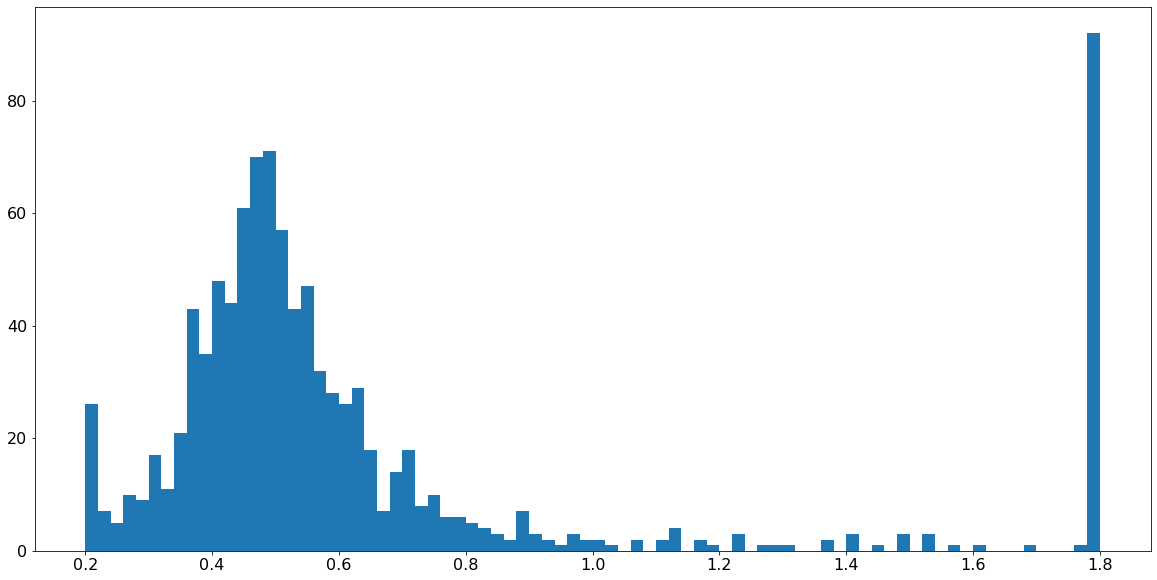

In [15]:
plt.figure(figsize=(20, 10))
plt.hist(ks.values(), bins=80)

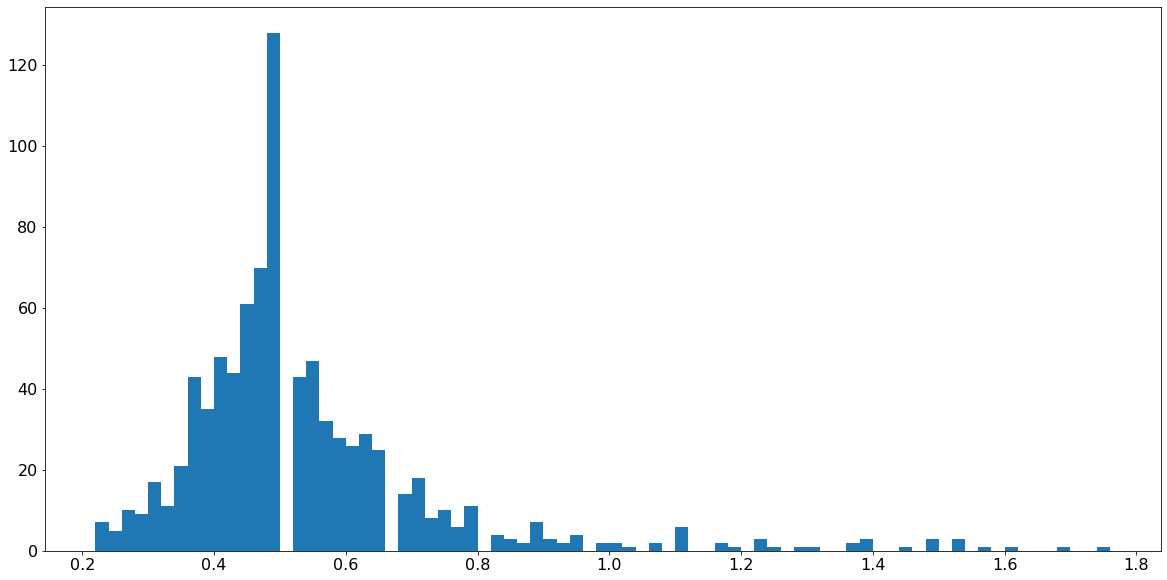

In [28]:
plt.figure(figsize=(20, 10))
counts, bins, _ = plt.hist([ x for x in ks.values() if x > 0.201 and x < 1.799 ], bins=77)

In [29]:
counts, bins

(array([  7.,   5.,  10.,   9.,  17.,  11.,  21.,  43.,  35.,  48.,  44.,
         61.,  70., 128.,   0.,  43.,  47.,  32.,  28.,  26.,  29.,  25.,
          0.,  14.,  18.,   8.,  10.,   6.,  11.,   0.,   4.,   3.,   2.,
          7.,   3.,   2.,   4.,   0.,   2.,   2.,   1.,   0.,   2.,   0.,
          6.,   0.,   0.,   2.,   1.,   0.,   3.,   1.,   0.,   1.,   1.,
          0.,   0.,   2.,   3.,   0.,   0.,   1.,   0.,   3.,   0.,   3.,
          0.,   1.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   1.]),
 array([0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  , 1.02, 1.04, 1.06, 1.08,
        1.1 , 1.12, 1.14, 1.16, 1.18, 1.2 , 1.22, 1.24, 1.26, 1.28, 1.3 ,
        1.32, 1.34, 1.36, 1.38, 1.4 , 1.42, 1.44, 1.46, 1.48, 1.5 , 1.52,
        1.54, 1.56, 1.58, 1.6 , 1.62

In [30]:
def gaussian(x, *pars):
    A, mu, sigma = pars
    return A * np.exp(-(x-mu)**2/2/sigma**2)

(0.4673427542708375, 0.008912338212712442, -0.10036954631552093)

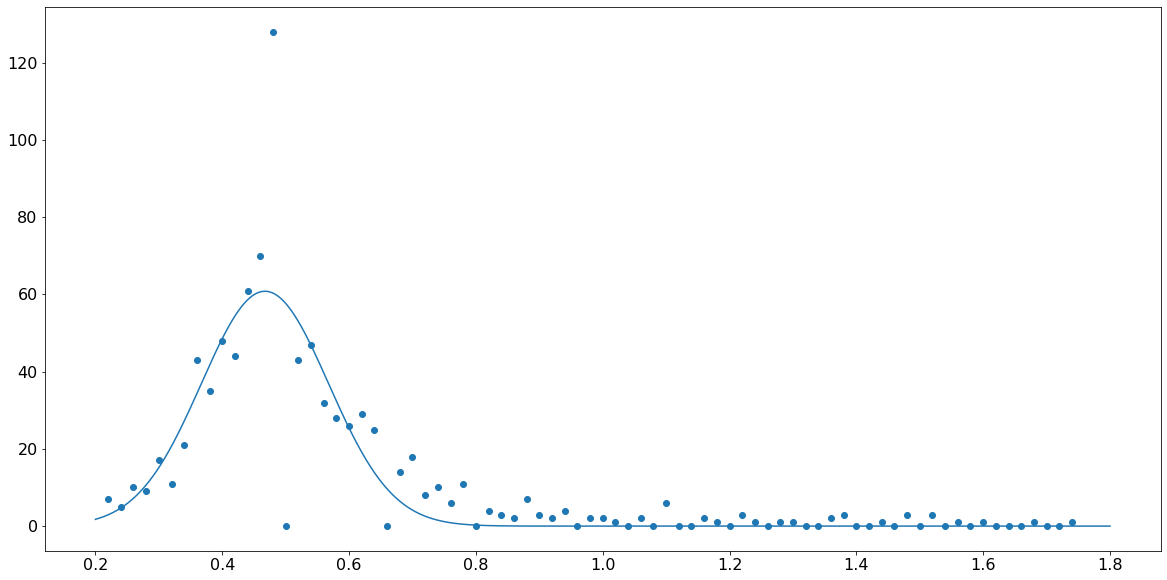

In [31]:
(A_fit, mu_fit, sigma_fit), var_matrix = curve_fit(gaussian, bins[:-1], counts, p0=[1, 0, 1])

xs = np.linspace(0.2, 1.8, 2000)
plt.figure(figsize=(20, 10))
plt.scatter(bins[:-1], counts)
plt.plot(xs, gaussian(xs, A_fit, mu_fit, sigma_fit))
mu_fit, var_matrix[1, 1]**.5, sigma_fit

In [33]:
ks_hr = {}
qs_hr = {}
for gaia_id in DF[:1000][GAIA_ID_COLNAME]:
    min_k, min_rmse, min_q = 100, 100, 100
    gaia_flux = plot_conv_get_gaia(gaia_id=gaia_id)
    if gaia_flux is None:
        continue
            
    for k in np.arange(0.2, 0.8, 0.0025):
        rmse, q = plot_conv_k_rms(gaia_flux, gaia_id=gaia_id, k=k)
        if rmse < min_rmse:
            min_rmse = rmse
            min_k = k
            min_q = q
        else:
            break
        
    ks_hr[gaia_id] = min_k
    qs_hr[gaia_id] = min_q

calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
Could not get SDSS data
Could not get SDSS data
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
Could not get SDSS data
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
Could not get SDSS data
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
Could not get SDSS data
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
Could not get SDSS data
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
Could not get SDSS data
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
Could not get SDSS data
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
Could not get SDSS data
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
Could not get SDSS data
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
Could not get SDSS data
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
Could not get SDSS data
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
Could not get SDSS data
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


In [35]:
ks_hr

{3217536339907648384: 0.5850000000000004,
 3697743267334291328: 0.8000000000000005,
 3683666666640754048: 0.6775000000000004,
 3683528776714709632: 0.6125000000000004,
 3683494176458551808: 0.5425000000000003,
 3658537736409397888: 0.8000000000000005,
 3694803688638177280: 0.3250000000000001,
 3649721512875483904: 0.4025000000000002,
 3652755958809710464: 0.5375000000000003,
 3695425290664568704: 0.46500000000000025,
 3649003463063106304: 0.8000000000000005,
 3217961747828046080: 0.8000000000000005,
 3683515410776636800: 0.8000000000000005,
 3217574234403744000: 0.46000000000000024,
 3637758792005488896: 0.4200000000000002,
 3073311956582747392: 0.5750000000000004,
 3694818222807582080: 0.5475000000000003,
 3793876214650688640: 0.3000000000000001,
 3661566306828100224: 0.46750000000000025,
 3659347256140256256: 0.8000000000000005,
 3685958598628554240: 0.2,
 3602512675468007808: 0.3975000000000002,
 3083085790322125056: 0.8000000000000005,
 3695495659409680896: 0.8000000000000005,
 383

In [36]:
qs_hr

{3217536339907648384: 1.0537340291399302,
 3697743267334291328: 1.088227838541742,
 3683666666640754048: 1.0727720086363186,
 3683528776714709632: 1.010450961867756,
 3683494176458551808: 1.0116129728165728,
 3658537736409397888: 1.2004786656937498,
 3694803688638177280: 1.122775218351665,
 3649721512875483904: 1.0256302451945942,
 3652755958809710464: 1.0444406536110606,
 3695425290664568704: 1.0205090410655937,
 3649003463063106304: 1.1927317126232955,
 3217961747828046080: 1.0353320391700616,
 3683515410776636800: 0.5696103488820679,
 3217574234403744000: 0.9754773726708733,
 3637758792005488896: 1.0372422380644295,
 3073311956582747392: 1.0339857182484387,
 3694818222807582080: 1.0551246117884916,
 3793876214650688640: 1.013276401023105,
 3661566306828100224: 0.7539862209532435,
 3659347256140256256: 1.0323452194553027,
 3685958598628554240: 1.0417095881807903,
 3602512675468007808: 0.9884280115312928,
 3083085790322125056: 0.990508237104872,
 3695495659409680896: 1.175579458014697

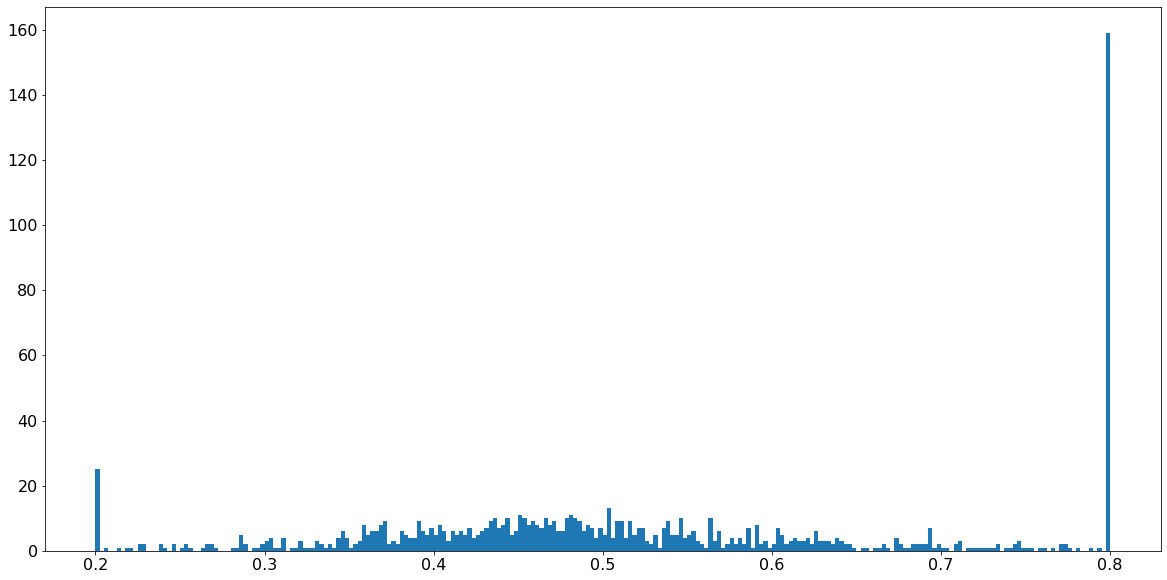

In [37]:
plt.figure(figsize=(20, 10))
counts2, bins2, _ = plt.hist(ks_hr.values(), bins=240)

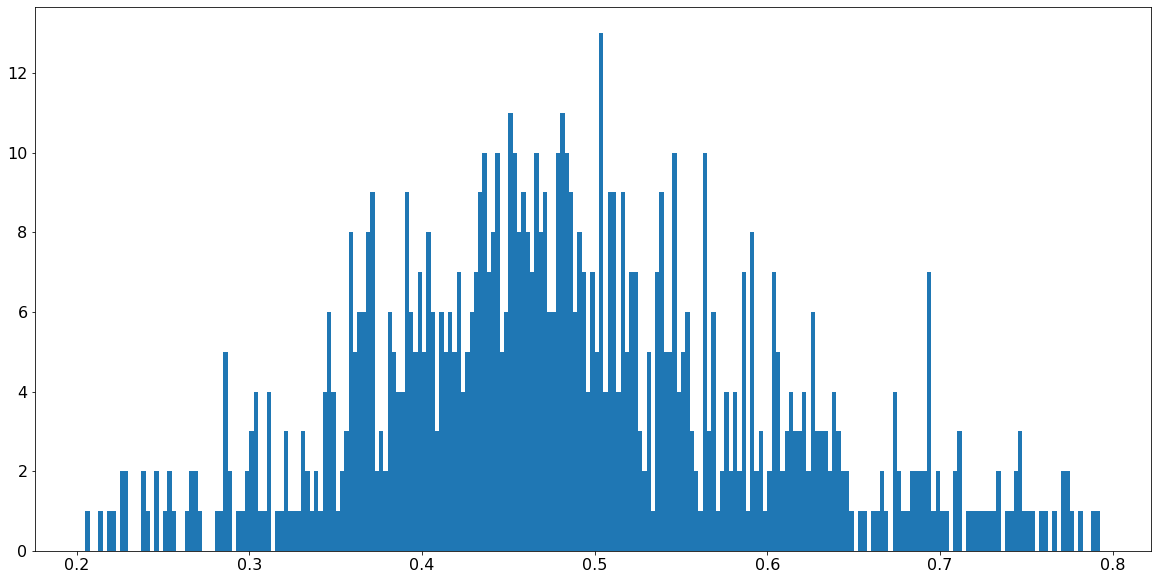

In [45]:
plt.figure(figsize=(20, 10))
counts2, bins2, _ = plt.hist([ x for x in ks_hr.values() if x > 0.20251 and x < 0.795 ], bins=235)

(0.47115140178411125, 0.004233585799651221, -0.10404353317686249)

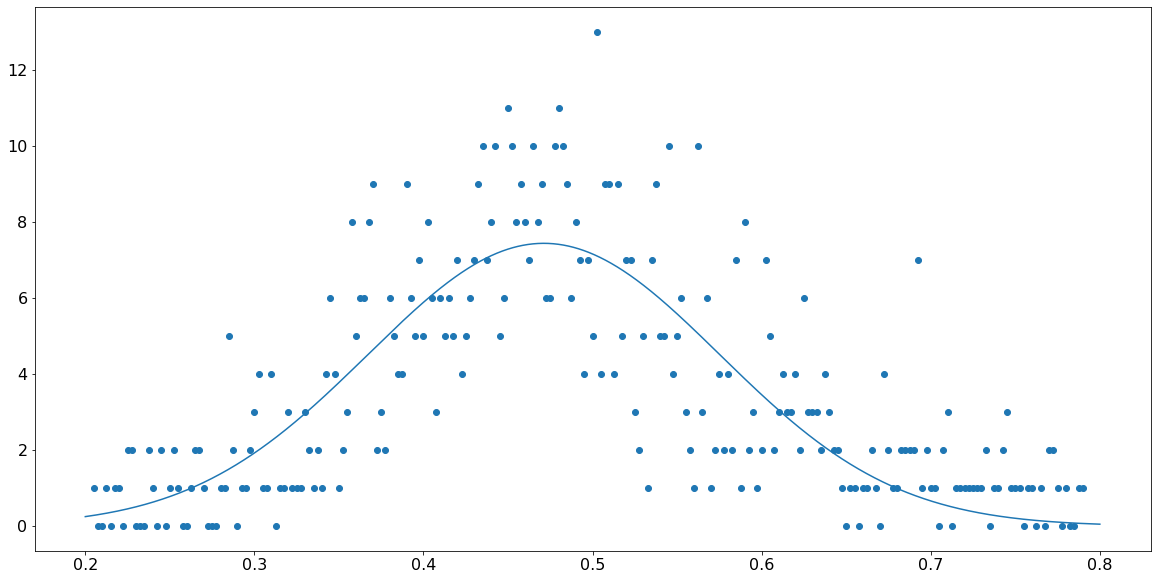

In [47]:
(A_fit, mu_fit, sigma_fit), var_matrix = curve_fit(gaussian, bins2[:-1], counts2, p0=[1, 0, 1])

xs = np.linspace(0.2, 0.8, 2000)
plt.figure(figsize=(20, 10))
plt.scatter(bins2[:-1], counts2)
plt.plot(xs, gaussian(xs, A_fit, mu_fit, sigma_fit))
mu_fit, var_matrix[1, 1]**.5, sigma_fit

In [52]:
ks_adj = {}
qs_adj = {}
for gaia_id in DF[:1000][GAIA_ID_COLNAME]:
    min_k, min_rmse, min_q = 100, 100, 100
    gaia_flux = plot_conv_get_gaia(gaia_id=gaia_id)
    if gaia_flux is None:
        continue
    else:
        gaia_flux *= qs_hr[gaia_id]
            
    for k in np.arange(0.2, 0.8, 0.0025):
        rmse, q = plot_conv_k_rms(gaia_flux, gaia_id=gaia_id, k=k)
        if rmse < min_rmse:
            min_rmse = rmse
            min_k = k
            min_q = q
        else:
            break
        
    ks_adj[gaia_id] = min_k
    qs_adj[gaia_id] = min_q

calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
Could not get SDSS data
Could not get SDSS data
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
Could not get SDSS data
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
Could not get SDSS data
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
Could not get SDSS data
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
Could not get SDSS data
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
Could not get SDSS data
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
Could not get SDSS data
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
Could not get SDSS data
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
Could not get SDSS data
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
Could not get SDSS data
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
Could not get SDSS data
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
Could not get SDSS data
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


calibrating gaia...


/home/noa/Data/radovi/gaia_sdss/venv/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.
calibrating gaia...


done.


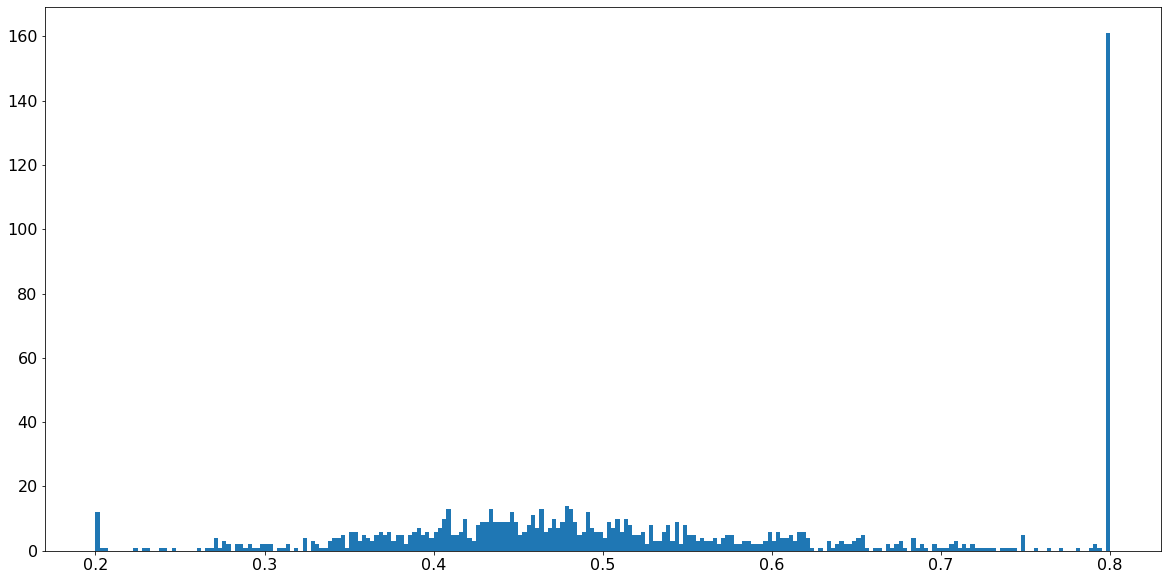

In [53]:
plt.figure(figsize=(20, 10))
counts_adj, bins_adj, _ = plt.hist(ks_adj.values(), bins=240)

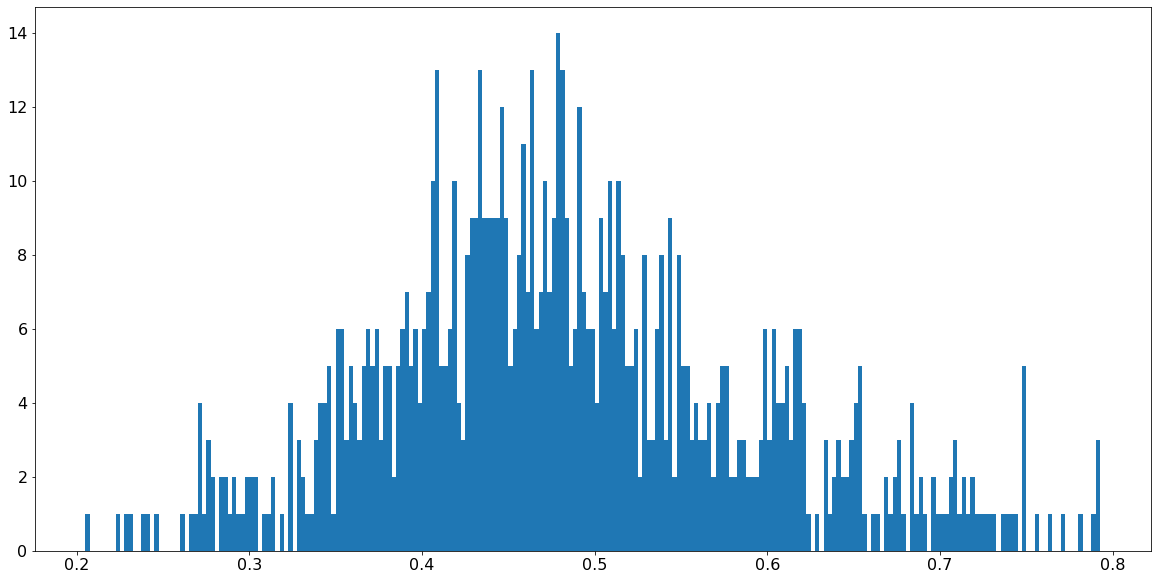

In [55]:
plt.figure(figsize=(20, 10))
counts_adj, bins_adj, _ = plt.hist([ x for x in ks_adj.values() if x > 0.20251 and x < 0.795 ], bins=235)

In [56]:
bins_adj

array([0.205 , 0.2075, 0.21  , 0.2125, 0.215 , 0.2175, 0.22  , 0.2225,
       0.225 , 0.2275, 0.23  , 0.2325, 0.235 , 0.2375, 0.24  , 0.2425,
       0.245 , 0.2475, 0.25  , 0.2525, 0.255 , 0.2575, 0.26  , 0.2625,
       0.265 , 0.2675, 0.27  , 0.2725, 0.275 , 0.2775, 0.28  , 0.2825,
       0.285 , 0.2875, 0.29  , 0.2925, 0.295 , 0.2975, 0.3   , 0.3025,
       0.305 , 0.3075, 0.31  , 0.3125, 0.315 , 0.3175, 0.32  , 0.3225,
       0.325 , 0.3275, 0.33  , 0.3325, 0.335 , 0.3375, 0.34  , 0.3425,
       0.345 , 0.3475, 0.35  , 0.3525, 0.355 , 0.3575, 0.36  , 0.3625,
       0.365 , 0.3675, 0.37  , 0.3725, 0.375 , 0.3775, 0.38  , 0.3825,
       0.385 , 0.3875, 0.39  , 0.3925, 0.395 , 0.3975, 0.4   , 0.4025,
       0.405 , 0.4075, 0.41  , 0.4125, 0.415 , 0.4175, 0.42  , 0.4225,
       0.425 , 0.4275, 0.43  , 0.4325, 0.435 , 0.4375, 0.44  , 0.4425,
       0.445 , 0.4475, 0.45  , 0.4525, 0.455 , 0.4575, 0.46  , 0.4625,
       0.465 , 0.4675, 0.47  , 0.4725, 0.475 , 0.4775, 0.48  , 0.4825,
      

(array([114.,   4.,   1.,   4.,   0.,   2.,   3.,   2.,   2.,   7.,   2.,
          4.,   3.,   4.,   2.,   0.,   1.,   0.,   1.,   1.]),
 array([0.    , 0.0265, 0.053 , 0.0795, 0.106 , 0.1325, 0.159 , 0.1855,
        0.212 , 0.2385, 0.265 , 0.2915, 0.318 , 0.3445, 0.371 , 0.3975,
        0.424 , 0.4505, 0.477 , 0.5035, 0.53  ]),
 <BarContainer object of 20 artists>)

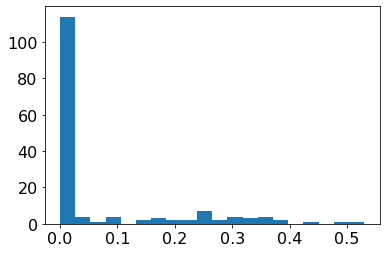

In [69]:
plt.hist(list({ gid: ks_hr[gid] - ks_adj[gid] for gid in ks_hr.keys() if np.abs(ks_hr[gid]) > 0.8 }.values()), bins=20)

(array([  2.,   2.,   2.,   1.,   1.,   4.,   2.,  13.,  16.,  11.,  18.,
         22.,  38.,  45., 100., 205., 196., 111.,  38.,  33.,  22.,  17.,
          8.,  11.,   6.,   2.,   7.,   7.,   3.,   4.]),
 array([0.52149713, 0.55223524, 0.58297335, 0.61371146, 0.64444958,
        0.67518769, 0.7059258 , 0.73666391, 0.76740202, 0.79814013,
        0.82887825, 0.85961636, 0.89035447, 0.92109258, 0.95183069,
        0.9825688 , 1.01330692, 1.04404503, 1.07478314, 1.10552125,
        1.13625936, 1.16699747, 1.19773558, 1.2284737 , 1.25921181,
        1.28994992, 1.32068803, 1.35142614, 1.38216425, 1.41290237,
        1.44364048]),
 <BarContainer object of 30 artists>)

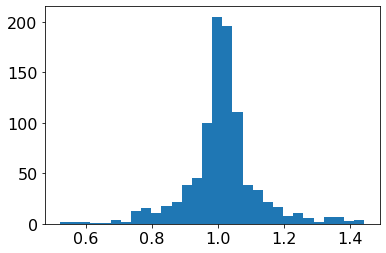

In [80]:
plt.hist([ x for x in qs_hr.values() if abs(x-1) < 0.5], bins=30)

In [81]:
ks_adj

{3217536339907648384: 0.5425000000000003,
 3697743267334291328: 0.8000000000000005,
 3683666666640754048: 0.6175000000000004,
 3683528776714709632: 0.6050000000000004,
 3683494176458551808: 0.5375000000000003,
 3658537736409397888: 0.8000000000000005,
 3694803688638177280: 0.3075000000000001,
 3649721512875483904: 0.3950000000000002,
 3652755958809710464: 0.5275000000000003,
 3695425290664568704: 0.44750000000000023,
 3649003463063106304: 0.8000000000000005,
 3217961747828046080: 0.8000000000000005,
 3683515410776636800: 0.6275000000000004,
 3217574234403744000: 0.47500000000000026,
 3637758792005488896: 0.4125000000000002,
 3073311956582747392: 0.5325000000000003,
 3694818222807582080: 0.5225000000000003,
 3793876214650688640: 0.2975000000000001,
 3661566306828100224: 0.6875000000000004,
 3659347256140256256: 0.8000000000000005,
 3685958598628554240: 0.2,
 3602512675468007808: 0.4000000000000002,
 3083085790322125056: 0.8000000000000005,
 3695495659409680896: 0.6050000000000004,
 3838

In [82]:
qs_adj

{3217536339907648384: 0.9988029405197536,
 3697743267334291328: 1.0000000000000002,
 3683666666640754048: 0.9993791061501667,
 3683528776714709632: 1.0001681408888803,
 3683494176458551808: 0.9999878680129938,
 3658537736409397888: 1.0000000000000002,
 3694803688638177280: 1.000475603378716,
 3649721512875483904: 1.0000160890568348,
 3652755958809710464: 0.9999589484571707,
 3695425290664568704: 1.0000410010248904,
 3649003463063106304: 1.0,
 3217961747828046080: 1.0,
 3683515410776636800: 0.9999157899182952,
 3217574234403744000: 1.0000679709247262,
 3637758792005488896: 1.0003077735836072,
 3073311956582747392: 1.0001650445143342,
 3694818222807582080: 0.9999144179568853,
 3793876214650688640: 1.0000004237517284,
 3661566306828100224: 0.9989450430098252,
 3659347256140256256: 1.0,
 3685958598628554240: 1.0,
 3602512675468007808: 1.0000142566379884,
 3083085790322125056: 1.0,
 3695495659409680896: 1.0029161914247475,
 3838954920078817920: 0.9997548304450045,
 3697644723605458688: 1.00